In [1]:
from DataParser import DataParser
import numpy as np
import pandas as pd
import scipy.sparse as sp

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Base.NonPersonalizedRecommender import TopPop
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 40})

%matplotlib inline

In [2]:
seed = 1024
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [3]:
URM_train.shape, URM_test.shape

((7947, 25975), (7947, 25975))

In [4]:
mat = URM_all.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_n = frame.groupby(['user_id']).size().reset_index(name='num_inter')
#frame_n

In [5]:
frame_n.loc[frame_n['num_inter'] >= 1410]

,user_id,num_inter
7382,7382,1653


In [6]:
mat = URM_train.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

mat = URM_test.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame_test = pd.DataFrame(data=d)
frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
#frame_join

In [7]:
def split_datasets(frame, size = 20):
    max_value = frame['num_inter'].max()
    frame_list=[]
    start_value = 0
    while start_value <= max_value:
        end_value = start_value+size
        sub_frame = frame_join.loc[(frame_join['num_inter'] >= start_value) & (frame_join['num_inter'] < end_value)].iloc[:,:3]
        if not sub_frame.empty:
            t = (start_value, end_value, sub_frame)
        else:
            t = (start_value, end_value, None)
        frame_list.append(t)
        start_value = end_value
    return frame_list

In [8]:
def compute_map_per_range(recommender, URM_test, range_size=20):
    map_list=[]
    
    URM_train = recommender.get_URM_train()
    mat = URM_train.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame = pd.DataFrame(data=d)
    frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

    mat = URM_test.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame_test = pd.DataFrame(data=d)
    frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
    
    frame_list = split_datasets(frame_join, range_size)
    
    for (start_value, end_value, sub_frame) in frame_list:
        if sub_frame is None:
            frame_map = None
            frame_len = None
        else:
            frame_len = len(sub_frame.user_id.unique())
            partial_urm_test = sp.csr_matrix((sub_frame.rating, (sub_frame.user_id, sub_frame.item_id)), 
                              shape=URM_train.shape)
            evaluator_test = EvaluatorHoldout(partial_urm_test, cutoff_list=[10])
            result, _ = evaluator_test.evaluateRecommender(recommender)
            frame_map = result[10]['MAP']
        map_list.append((start_value, end_value, frame_map, frame_len))
    
    return map_list
    

In [9]:
def frame_to_plot(map_list):
    x = []
    y = []
    z = []
    for (low, high, val, support) in map_list:
        x_val = str(low)+'-'+str(high)
        if val is None:
            #y.append(0)
            continue
        else:
            y.append(val)
        x.append(x_val)
        z.append(support)
    return x,y,z

In [27]:
def plot_frame(x,y):
    figure(num=None, figsize=(100, 20), dpi=80, facecolor='w', edgecolor='k')
    axes = plt.gca()
    #axis_font = {'fontname':'Arial', 'size':'22'}
    #axes.set_ylim([0,0.3])
    plt.bar(x, y, align='center')
    plt.xticks(range(len(x)), x)
    for label in (plt.get_xticklabels() + plt.get_yticklabels()):
        label.set_fontsize(22)

In [11]:
rec1 = ItemKNNCBFRecommender(URM_train, ICM_all)
rec1.fit(topK=40, shrink=1000, similarity='cosine', feature_weighting='BM25')
result_eval, _ = evaluator_test.evaluateRecommender(rec1) 

ItemKNNCBFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCBFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 5421.19 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.54 sec. Users per second: 1966


In [12]:
map_list = compute_map_per_range(rec1, URM_test, range_size=50)

EvaluatorHoldout: Processed 4655 ( 100.00% ) in 2.32 sec. Users per second: 2009
EvaluatorHoldout: Processed 194 ( 100.00% ) in 0.13 sec. Users per second: 1550
EvaluatorHoldout: Processed 49 ( 100.00% ) in 0.04 sec. Users per second: 1312
EvaluatorHoldout: Processed 31 ( 100.00% ) in 0.03 sec. Users per second: 1200
EvaluatorHoldout: Processed 9 ( 100.00% ) in 0.01 sec. Users per second: 718
EvaluatorHoldout: Processed 7 ( 100.00% ) in 0.01 sec. Users per second: 617
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 377
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 327
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 128
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 295


/home/filippo/challenge/RecSys-2020/Base/Evaluation/metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 318
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 137
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 175
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 133
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 183


In [13]:
#map_list

In [14]:
x,y,_ = frame_to_plot(map_list)
frame_knn = pd.DataFrame({'range':x, 'MAP':y})
#frame_knn

AttributeError: module 'matplotlib.pyplot' has no attribute 'get_xticklabels'

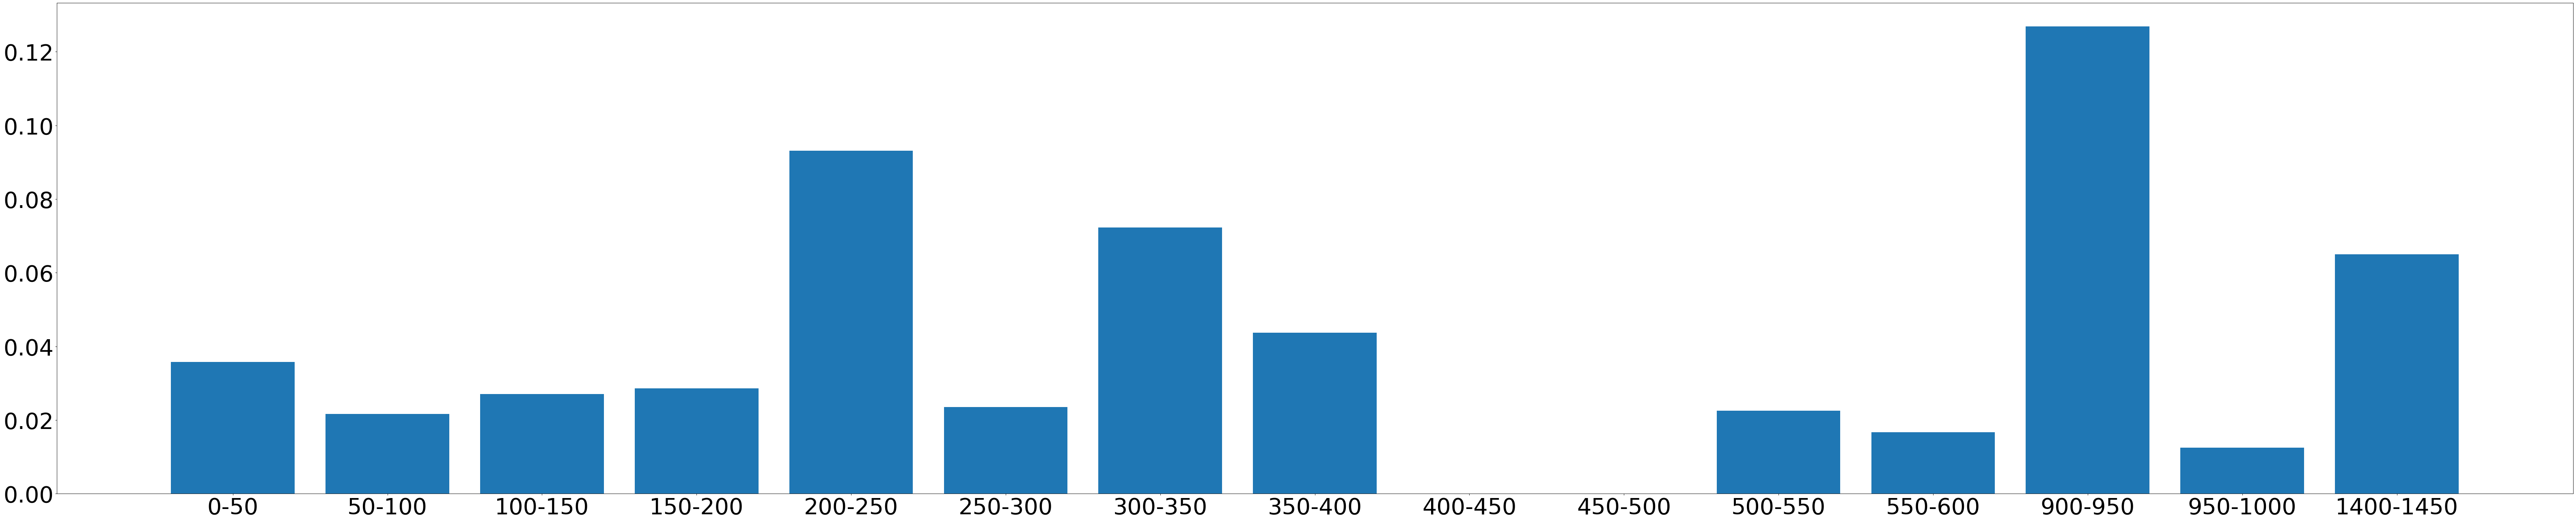

In [28]:
plot_frame(x,y)

In [ ]:
rec_top = TopPop(URM_train)
rec_top.fit()
compute_map_per_range(rec_top, URM_test, range_size=30)